In [1]:
import pandas as pd
import glob
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# Ładowanie danych

In [2]:
path = "scale_data/merged/"

all_files = glob.glob(path + "*")
# print(all_files)

def read_csv(f):
    return pd.read_csv(f, engine="python", delimiter="impossible_delimiter_to_read_line_by_line", names=[os.path.basename(f)])

def reset_index(df):
    df.reset_index(drop=True, inplace=True)

dataframes = [read_csv(f) for f in all_files]

df = pd.concat(dataframes, axis=1)

df.head()

,id,label_3class,label_4class,rating,subj
0,29420,0,0,0.1,"in my opinion , a movie reviewer's most import..."
1,17219,0,0,0.2,"you can watch this movie , that is based on a ..."
2,18406,0,0,0.2,"this is asking a lot to believe , and though i..."
3,18648,0,0,0.2,no heroes and no story are the main attributes...
4,20021,0,0,0.2,"this is not an art movie , yet i saw it an art..."


# Analiza danych
## Rozkład ocen

,label_3class,counts
0,0,1197
1,1,1915
2,2,1894


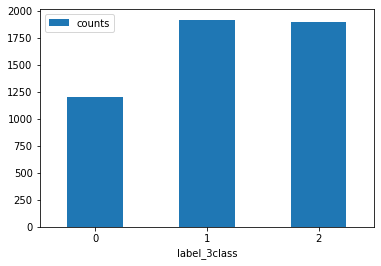

In [3]:
c = df.groupby('label_3class').size().reset_index(name='counts')
c.plot.bar(x='label_3class', y="counts", rot=0)
c

,label_4class,counts
0,0,615
1,1,1553
2,2,1998
3,3,840


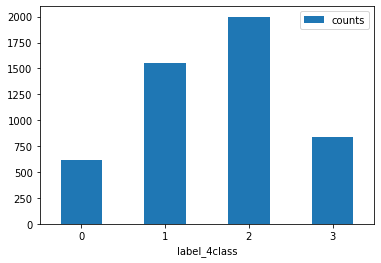

In [4]:
c = df.groupby('label_4class').size().reset_index(name='counts')
c.plot.bar(x='label_4class', y="counts", rot=0)
c

## Typowe długości recenzji

In [5]:
subj_len_list = df.subj.map(len)

print('Przeciętna długość recenzji: ' + str(subj_len_list.mean()))

subj_len_list.reset_index(name='len')[['len']].groupby('len').size().T.sort_values(ascending=False).head(15).reset_index(name='count')

Przeciętna długość recenzji: 2256.4578505793047


,len,count
0,2414,8
1,1717,8
2,2146,7
3,2786,7
4,2726,6
5,2152,6
6,2420,6
7,3013,6
8,1473,6
9,1703,6


## Najczęściej występujące słowa:

### Wszystkie:

In [6]:
all_data_cv = CountVectorizer()
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41932


,index,counts
0,the,112685
1,of,55778
2,and,48379
3,to,44245
4,is,39599
5,it,32405
6,in,28737
7,that,25740
8,for,18343
9,as,17585


### Używając stop_words

In [7]:
all_data_cv = CountVectorizer(stop_words='english')
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41631


,index,counts
0,film,17304
1,movie,9601
2,like,6194
3,story,5363
4,director,3954
5,just,3849
6,time,3845
7,films,3453
8,characters,3240
9,good,3170


# System do maszynowego uczenia (TODO)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.subj, df.label_3class)

In [9]:
v = CountVectorizer(stop_words='english')
X_train_count = v.fit_transform(X_train.values)
X_train_count.toarray()[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
X_test_count = v.transform(X_test)

In [11]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [12]:
model.predict(X_test_count)

array([1, 1, 1, ..., 2, 1, 1], dtype=int64)

In [13]:
model.score(X_test_count, y_test)

0.6142172523961661

In [14]:
X_test.head()

595     an enjoyable monogram made charlie chan myster...
1422    the program is a real mish-mash of cliches . i...
1061    along the way , they encounter numerous routin...
3653    1994's the yearling uses exaggerated hillbilly...
3953    what has happened to these people since , and ...
Name: subj, dtype: object

In [15]:
clf = svm.SVC()
clf.fit(X_train_count, y_train)

SVC()

In [16]:
clf.predict(X_test_count)

array([1, 1, 0, ..., 2, 1, 1], dtype=int64)

In [17]:
clf.score(X_test_count, y_test)

0.6317891373801917